<a href="https://colab.research.google.com/github/Deca97/Anaerobic_Threshold_Test/blob/main/Test_Conconi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fitdecode




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.1 MB/s eta 0:00:00


<ipython-input-94-cb2afa9e7542>:53: RuntimeWarning: divide by zero encountered in divide
  diffs = np.diff(smoothed_heart_rates) / np.diff(smoothed_speeds)


Estimated Anaerobic Threshold Heart Rate: 168 bpm
Estimated Anaerobic Threshold Pace: 3:32 min/km
Estimated Anaerobic Threshold Speed: 4.712 m/s


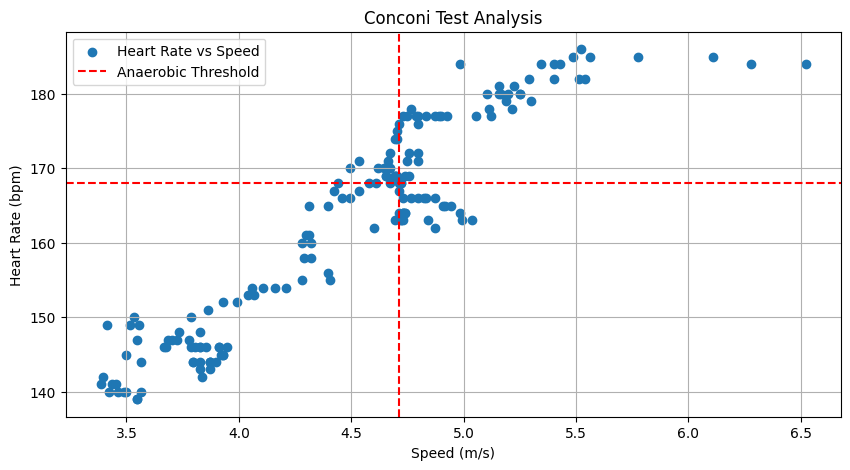

In [94]:
import fitdecode
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def get_conconi_data(fit_file_path):
    """
    Extracts heart rate and speed/pace data from a Garmin FIT file representing a Conconi test.
    """
    heart_rates = []
    speeds = []
    try:
        with fitdecode.FitReader(fit_file_path) as fit_file:
            for frame in fit_file:
                if frame.frame_type == fitdecode.FIT_FRAME_DATA and frame.name == "record":
                    heart_rate = frame.get_value('heart_rate')
                    speed = frame.get_value('speed')

                    if heart_rate is not None and speed is not None:
                        heart_rates.append(heart_rate)
                        speeds.append(speed)
    except Exception as e:
        print(f"Error processing FIT file: {e}")
        return [], []

    return heart_rates, speeds



def smooth_data(data, window_size):
    """
    Applies a simple moving average smoothing to a dataset.
    """
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data.tolist()

def calculate_anaerobic_threshold(heart_rates, speeds):
    """
    Calculates the anaerobic threshold using the Conconi method with improved detection of the threshold.
    """
    if not heart_rates or not speeds:
        return None, None

    window_size = 50  # Averaging window size
    smoothed_heart_rates = np.convolve(heart_rates, np.ones(window_size)/window_size, mode='valid')
    smoothed_speeds = np.convolve(speeds, np.ones(window_size)/window_size, mode='valid')

    min_length = min(len(smoothed_heart_rates), len(smoothed_speeds))
    smoothed_heart_rates = smoothed_heart_rates[:min_length]
    smoothed_speeds = smoothed_speeds[:min_length]

    # Compute first derivative
    diffs = np.diff(smoothed_heart_rates) / np.diff(smoothed_speeds)

    # Define a range of indices to look at (previous n data points)
    lookback_range = 50  # Number of points to compare with (previous n data points)
    for i in range(lookback_range, len(diffs)):
        # Calculate the average slope of the previous `lookback_range` points
        avg_diff_prev = np.mean(diffs[i-lookback_range:i])

        # Compare the current slope to the average slope of the previous points
        if diffs[i] < avg_diff_prev * 0.2:  # Detect drop in slope relative to the rolling average
            conconi_index = i + window_size // 2  # Adjust for smoothing
            if conconi_index < len(heart_rates) and conconi_index < len(speeds):
                return heart_rates[conconi_index], speeds[conconi_index], min_length

    return None, None


def calculate_pace(speed):
    """
    Converts speed (m/s) to pace (min/km).
    """
    if speed == 0:
        return "N/A"
    pace_seconds_per_km = 1000 / speed
    minutes = int(pace_seconds_per_km // 60)
    seconds = int(pace_seconds_per_km % 60)
    return f"{minutes}:{seconds:02d}"

# Load data
fit_file_path = "/7112584418_ACTIVITY.fit"  # Assicurati che il file sia nel path corretto
heart_rates, speeds = get_conconi_data(fit_file_path)

# Remove first n elements
n_remove = 20  # Adjust this value as needed
heart_rates = heart_rates[n_remove:]
speeds = speeds[n_remove:]


# Compute anaerobic threshold
if heart_rates and speeds:
    anaerobic_threshold_hr, anaerobic_threshold_speed, min_length = calculate_anaerobic_threshold(heart_rates, speeds)
    if anaerobic_threshold_hr is not None and anaerobic_threshold_speed is not None:
        pace = calculate_pace(anaerobic_threshold_speed)
        print(f"Estimated Anaerobic Threshold Heart Rate: {anaerobic_threshold_hr} bpm")
        print(f"Estimated Anaerobic Threshold Pace: {pace} min/km")
        print(f"Estimated Anaerobic Threshold Speed: {anaerobic_threshold_speed} m/s")
    else:
        print("Could not determine anaerobic threshold.")
else:
    print("No data found in the FIT file.")

# Plot results


plt.figure(figsize=(10, 5))
plt.scatter(speeds, heart_rates, marker='o', linestyle='-', label='Heart Rate vs Speed')
if anaerobic_threshold_hr and anaerobic_threshold_speed:
    plt.axvline(x=anaerobic_threshold_speed, color='r', linestyle='--', label='Anaerobic Threshold')
    plt.axhline(y=anaerobic_threshold_hr, color='r', linestyle='--')
plt.xlabel('Speed (m/s)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Conconi Test Analysis')
plt.legend()
plt.grid()
plt.show()
